In [26]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np 
import pandas as pd

kmax = 40
lamb = 0.3
rho = 1/4
vax_rate = .40

I0 = 0.01 #initial fraction of infected nodes

# Initial conditions

pk_arr = np.array([rho*(1-rho)**k for k in range(1, kmax + 1)])

#SVk = pk_arr*(vax_rate)*(1-I0) ## proportion of nodes susceptible vaccinated
#SUk = pk_arr*(1-vax_rate)*(1-I0) ## proportion of nodes susceptible unvaccinated
IVk = pk_arr*(vax_rate)*(I0) 
IUk = pk_arr*(1-vax_rate)*(I0)

full_initial_c = np.concatenate([IVk, IUk])

In [25]:
def decompose_full_arr(arr, kmax):
    IVk = arr[0:kmax]
    IUk = arr[kmax:(kmax*2)]

    return IVk, IUk

def SIS_net(w, t, p):
    ## https://scipy-cookbook.readthedocs.io/items/CoupledSpringMassSystem.html
    lamb, vax_rate, rho, kmax = p

    ks = np.arange(1, kmax+1)
    pk = np.array([rho*(1-rho)**k for k in range(1, kmax + 1)])
    
    IVk, IUk = decompose_full_arr(w, kmax)

    theta = ((1-rho)*sum(IVk*ks) + sum(IUk*ks))/sum(ks*pk)

    IVk_dt = lamb*theta*ks*(1-rho)*(vax_rate*pk - IVk) - IVk
    IUk_dt = lamb*theta*ks*((1-vax_rate)*pk - IUk) - IUk
    #SVk_dt = vax_rate*pk - IVk
    #SUk_dt = pk - IVk_dt - IUk_dt - SVk_dt

    full_status = np.concatenate([IVk_dt, IUk_dt])
    
    return full_status

def run_integrator(initial_I, rho, numpoints, stoptime = 10.0, abserr = 1.0e-8, relerr = 1.0e-6):
    p = [lamb, vax_rate, rho, kmax]
    t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]
    wsol = odeint(SIS_net, initial_I, t, args=(p,))
    result_list =  [tuple(decompose_full_arr(ts, kmax)) for ts in (wsol.tolist())]
    infected_ts = [sum(obs[0]) + sum(obs[1]) for obs in result_list]
    return pd.DataFrame.from_dict({"rho": rho, "ts": np.arange(0, numpoints),  "infected": infected_ts})


In [61]:
rho_test = np.arange(.05, .95, .05)
rho_simulation_result = [run_integrator(full_initial_c, rho, 5000) for rho in rho_test  ]
rho_result_pd = pd.concat(rho_simulation_result)

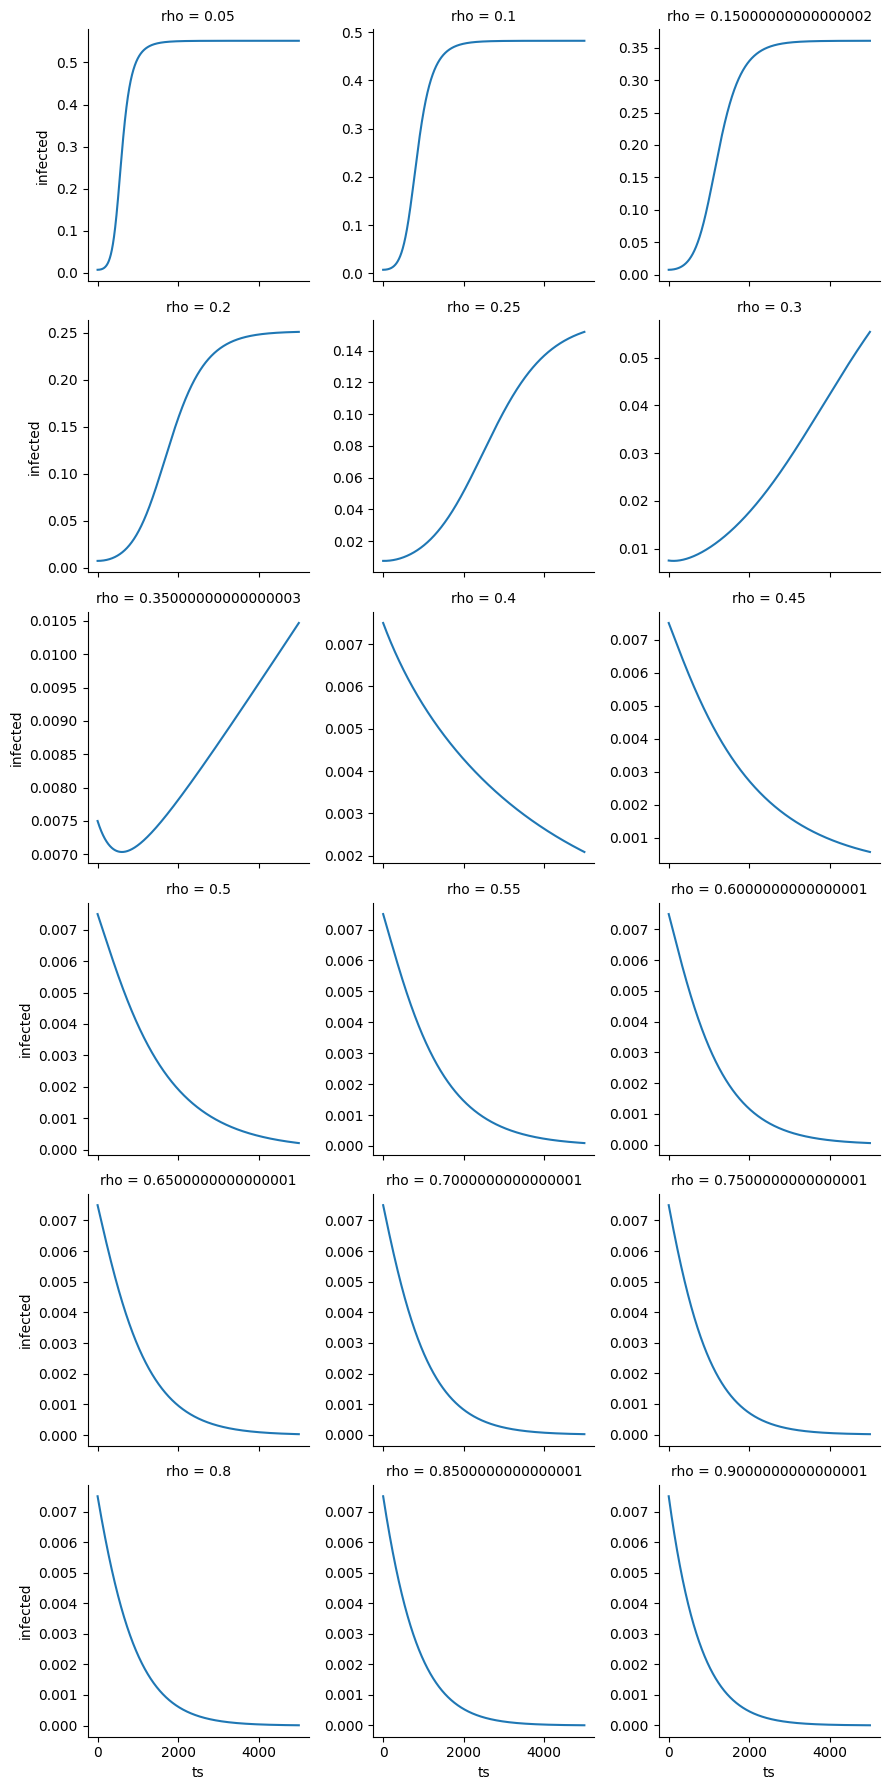

In [66]:
import seaborn as sns

g = sns.FacetGrid(rho_result_pd, col = "rho", col_wrap = 3, sharey = False)
g.map_dataframe(sns.lineplot, x = "ts", y = "infected")

In [54]:
vax_d = np.zeros(kmax)
vax_d[-1] = pk_arr[-1]*vax_rate

unvax_d = pk_arr
unvax_d[-1] = pk_arr[-1]*(1-vax_rate)

IVk_d = vax_d*(I0) 
IUk_d = unvax_d*(I0)

full_initial_d = np.concatenate([IVk_d, IUk_d])

In [63]:
rho_simulation_result_d = [run_integrator(full_initial_d, rho, 5000) for rho in rho_test  ]
rho_result_d_pd = pd.concat(rho_simulation_result_d)

In [64]:
rho_result_d_pd["part"] = "d"
rho_result_pd["part"] = "c"
all_rho_results = pd.concat([rho_result_d_pd, rho_result_pd])

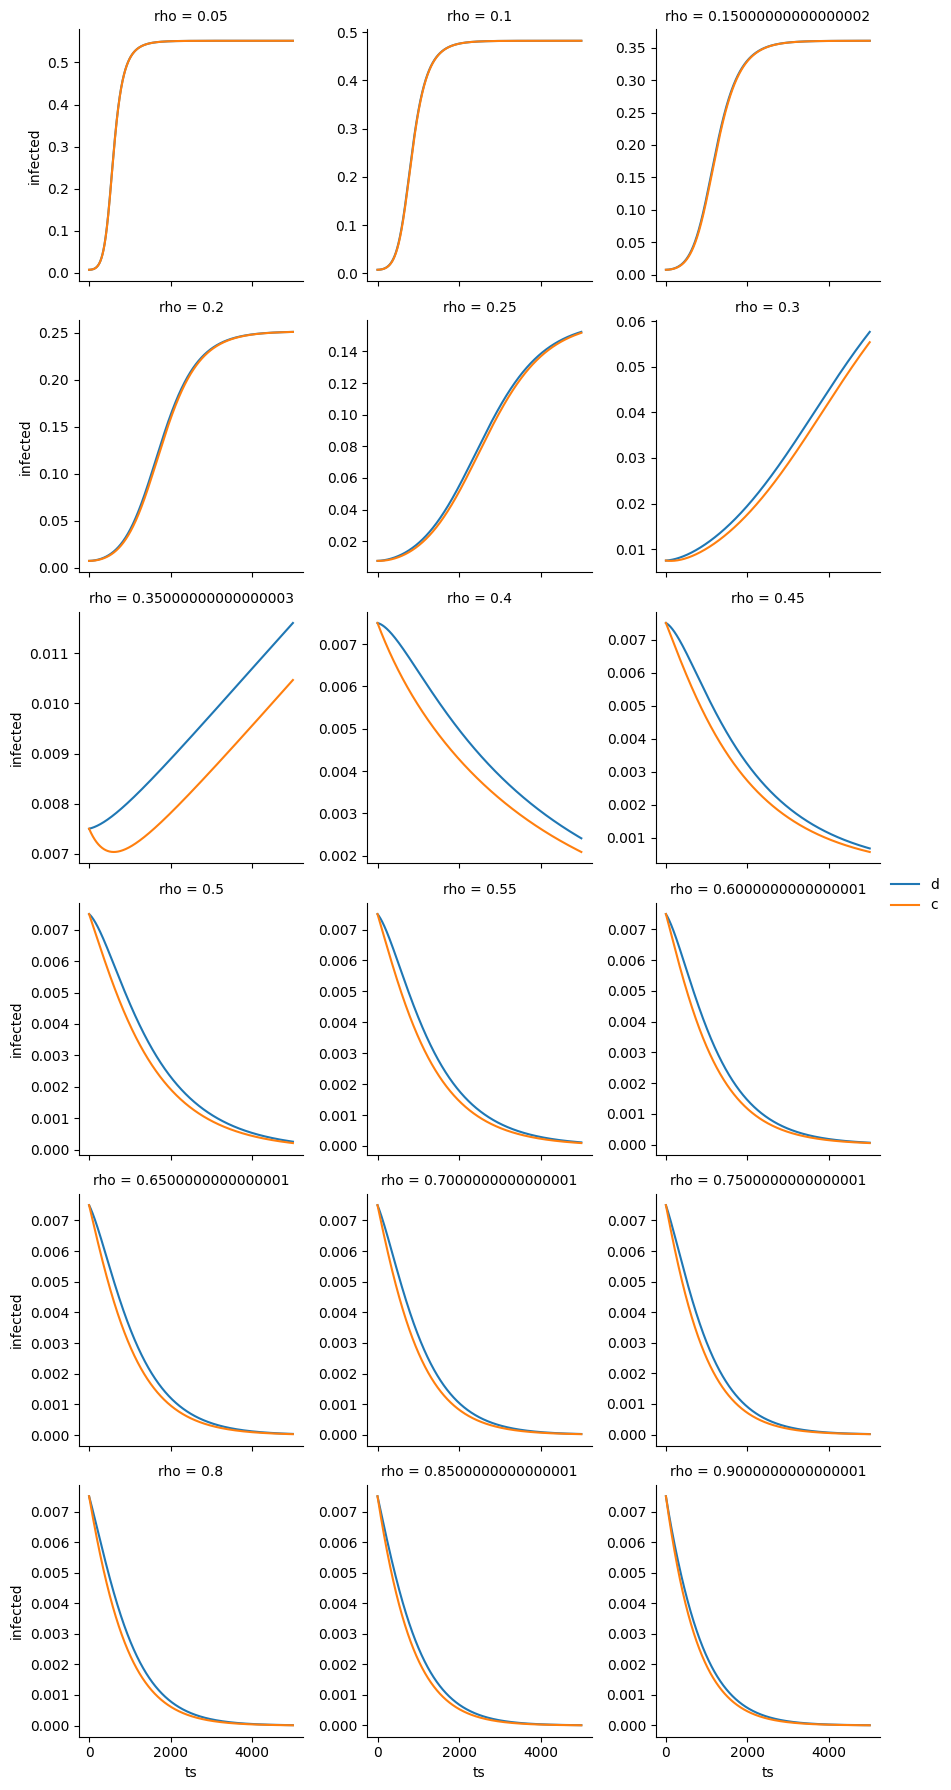

In [68]:
g = sns.FacetGrid(all_rho_results, col = "rho", col_wrap = 3, sharey = False)
g.map_dataframe(sns.lineplot, x = "ts", y = "infected", hue = "part")
g.add_legend()